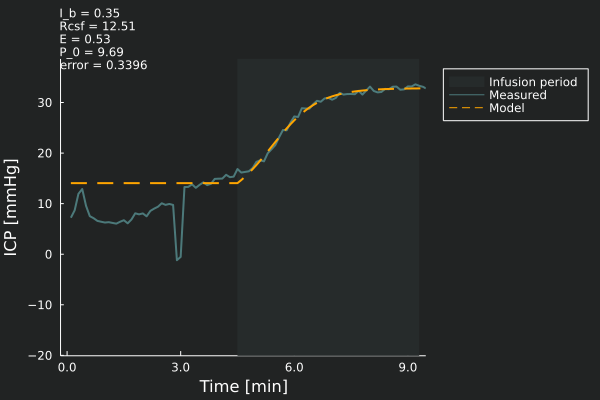

In [26]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=0.1, E=0.1, Ib=0.1, P0=0.1, mode="NaN", error=0.0, R2=0.0, Pss=NaN)

for j = 100
    # try
        j in [278, 442, 521, 621, 676, 1043] ? (continue) : 0

        filename = files[j]
        global Data = readCSF(filename)


        # diffRcsf, diffE, diffP0 = solveDerivatives()

        length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
        global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

        lb = [0.1, 0.1, -10.0]
        ub = [50.0, 1.0, Data["P_b"]]
        Ib_upper = 1.0
        Ib_lower = 0.0

        # optalg = Newton()
        optalg = NelderMead()
        x0 = [Data["Rcsf"], Data["E"], Data["P_0"]]
        # x0 = [10.86956959474335, 0.4499916171315348, 15.693581263018846]
        result, min_val = local_opt(x0, optalg)
        global Rcsf, E, P_0 = Optim.minimizer(result)

        # get_error_score(x0...)
        global I_b = (Data["P_b"] - P_0) / Rcsf

        df.Rcsf[j] = round(Rcsf, digits=3)
        df.P0[j] = round(P_0, digits=3)
        df.Ib[j] = round(I_b, digits=3)
        df.E[j] = round(E, digits=3)
        df.filename[j] = filename[length(datapath)+2:end]
        df.error[j] = round(get_error_score(Rcsf, E, P_0), digits=3)
        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0)
        df.R2[j] = round(R2, digits=3)

        # plot_model(logit(I_b, Ib_lower, Ib_upper), logit(E, lb[2], ub[2]), logit(P_0, lb[3], ub[3]), Data["ICP"], 20, false)
        # plot_model(I_b, E, P_0, Data["ICP"], 20, false)
        # println(j)
    # catch
    #     println("failed at file $j")
    #     continue
    # end
end
# CSV.write("/Users/jjc/CSF/Results/Results_Newton.csv", df);
plot_model(I_b, E, P_0, Data["ICP"], 20, false)
Rdist = LinRange(0.0, 50.0, 1000)
Edist = LinRange(0.0, 1.0, 100)
P0dist = LinRange(-10.0, Data["P_b"], 100)
# P0dist = zeros(100) .+ Data["P_0"]

# M = [[i,j,k, get_error_score(i, j, k)]  for i in Rdist, j in Edist, k in P0dist]
a = reshape(M,10000000,1)
a[1:end][4]

tormv = zeros(length(a))
for i = 1:length(a)
    isnan.(a[i][4]) ? a[i][4] = 10^12 : 0
    tormv[i] = a[i][4]
end

# minimum(a...)
s = findmin(tormv)
s = s[2]
I_b =(Data["P_b"] - a[s][3]) / a[s][1]
global Rcsf = a[s][1]
plot_model(I_b, a[s][2], a[s][3], Data["ICP"], 20, false)

In [28]:
CSV.write("/Users/jjc/CSF/Results/Results_Newton.csv", df);

In [14]:
Data

Dict{String, Any} with 19 entries:
  "end_time"             => DateTime("2003-11-14T17:20:58.309")
  "P_0"                  => 18.21
  "T"                    => [0.0, 0.166667, 0.333333, 0.5, 0.666667, 0.833333, …
  "Rcsf"                 => 10.81
  "P_b"                  => 19.04
  "AMP"                  => [NaN, 3.51079, 2.39618, 2.53668, 3.07261, 2.75482, …
  "start_time"           => DateTime("2003-11-14T16:39:18.309")
  "I_inf"                => 1.0
  "one_needle"           => 0
  "I_b"                  => 0.08
  "infusion_start_frame" => 66
  "plateau_start"        => 138
  "plateau_end"          => 178
  "E"                    => 0.85
  "rec_dur_s"            => 2500.0
  "ICP"                  => [19.924, 19.7965, 19.6145, 20.3458, 21.1477, 20.128…
  "P_p"                  => 30.24
  "infusion_end_frame"   => 178
  "Rn"                   => 0